In [161]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Gradient flow through targets of canned losses in torch.nn module

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable

BATCH_SIZE = 16

criterion_mse = nn.MSELoss()
x = Variable(torch.FloatTensor( BATCH_SIZE , 10  )  )
l = nn.Linear( 10 , 10 )
y = l(x)
loss = criterion_mse( y, x )

#### Loading large csv file with pandas

In [5]:
import pandas as pd
import csv, sys

csv.field_size_limit(sys.maxsize)

131072

In [6]:
cities_df = pd.read_csv("/home/data/world-cities/cities_over_10kpop.csv", engine='python')

In [7]:
cities_df.head()

,Unnamed: 0,city,province,country,countrycode,geometry,City,area,scale,location,region,subregion,population,size
0,0,bc,ha bnh,vietnam,vnm,"POLYGON ((104.9122238159183 21.10770416259777,...","bc, ha bnh, vnm",822.327067,47.977300,POINT (105.0898583753079 20.90473936175678),Asia,South-Eastern Asia,118347.0,small-1
1,1,huoai,lm ng,vietnam,vnm,"POLYGON ((107.6680145263674 11.58079624176042,...","huoai, lm ng, vnm",496.499818,35.334831,POINT (107.6350995141158 11.43013124076439),Asia,South-Eastern Asia,83501.0,very-small
2,2,lng,ngh an,vietnam,vnm,"POLYGON ((105.3113555908204 19.02108001709013,...","lng, ngh an, vnm",354.262448,31.091116,POINT (105.3444188206974 18.89951705506391),Asia,South-Eastern Asia,315258.0,small-2
3,3,lt,lm ng,vietnam,vnm,"POLYGON ((108.4629898071291 12.00575256347656,...","lt, lm ng, vnm",394.133348,30.273768,POINT (108.4633632381151 11.92087681897704),Asia,South-Eastern Asia,25987.0,very-small
4,4,mn,cn th,vietnam,vnm,"POLYGON ((105.6183471679687 10.18791675567621,...","mn, cn th, vnm",130.334309,17.562443,POINT (105.6329062950626 10.12685462746253),Asia,South-Eastern Asia,116948.0,small-1


#### Splitting files of a directory into train, valid, test splits

In [43]:
import glob
import os
import pandas as pd
import numpy as np

In [50]:
np.random.shuffle(sample_names)

In [55]:
files = glob.glob("/home/data/world-cities/spatial-maps/samples/*")
files_df = pd.DataFrame(map(lambda f: (f,) + os.path.splitext(os.path.basename(f)), 
                 files), columns=["filename", "sample", "ext"])
files_df['sample'] = files_df['sample'].apply(lambda x: x.replace(".pickle", ""))
files_df.set_index("sample", inplace=True)
sample_names = files_df.index.unique().values
frac_train = 0.8
frac_valid = frac_test = 0.1
len_splits = [int(frac_train*len(sample_names)), int((frac_train+frac_valid)*len(sample_names))]
np.random.shuffle(sample_names)
train_idx, valid_idx, test_idx = np.split(sample_names, len_splits)


In [61]:
train_idx.shape, valid_idx.shape, test_idx.shape

((24701,), (3088,), (3088,))

In [59]:
train_files = files_df.loc[train_idx]['filename'].values
valid_files = files_df.loc[valid_idx]['filename'].values
test_files  = files_df.loc[test_idx]['filename'].values


In [60]:
len(train_files), len(valid_files), len(test_files)

(49402, 6176, 6176)

#### Operations on images

In [71]:
from PIL import Image
from scipy.ndimage.interpolation import rotate

img = np.random.random((3,3,4))
print img.shape

img_rot = rotate(img, 30, reshape=False)
print img_rot.shape

# Image.fromarray(img)

(3, 3, 4)
(3, 3, 4)


In [107]:
type(img_rot)

numpy.ndarray

#### Testing loader for DataFolder 

In [911]:
import sys
sys.path.append("/home/nbserver/BEGAN-pytorch/")
import data_loader as dl
reload(dl)
from datafolder import basic_preprocess, default_loader, flip_ndimage
from utils import save_image_channels

from skimage.io import imread

In [986]:
normalize_channels = ([0, 160.91, 1.295, 0, 0],
                      [1, 1010.413, 15.326, 1, 1])
normalize = True
take_log = False #[1,2]
rotate_angle = 0
res_scale = 64

loader = dl.get_loader("/home/data/world-cities/spatial-maps/", "train", 
                       8, res_scale, 
                       load_attributes=["region", "profiles"], 
                       rotate_angle=rotate_angle, 
                       normalize=normalize, 
                       take_log=take_log)
loader = iter(loader)

Loading data from /home/data/world-cities/spatial-maps/splits/train
Found 24681 images in subfolders of: /home/data/world-cities/spatial-maps/splits/train


Mean [0.1899999976158142, 0.02199999988079071, 0.029999999329447746, 0.5139999985694885, 0.22499999403953552]
Stdv [0.3930000066757202, 0.05999999865889549, 0.0729999989271164, 0.5, 0.4169999957084656]
Min  [0.0, 0.0, 0.0, 0.0, 0.0]
Max  [1.0, 1.0, 1.0, 1.0, 1.0]
brazil_miranda_very-small_26857_-20.1201_-56.5980
direct: ['0.0000-1.0000', '0.0000-1922.0000', '0.0000-27.0000', '0.0000-1.0000', '0.0000-1.0000']
torch : ['0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000', '0.0000-0.0000', '0.0000-1.0000']
prepr: ['0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000', '0.0000-0.0000', '0.0000-1.0000']


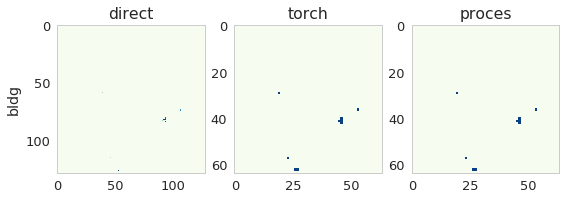

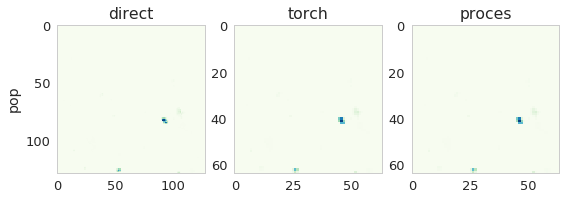

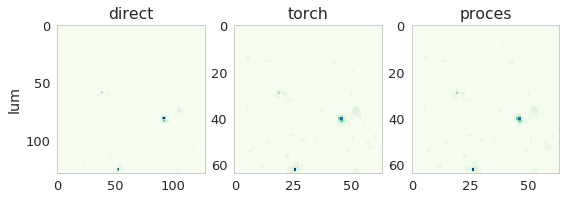

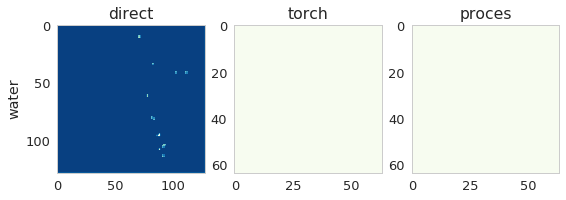

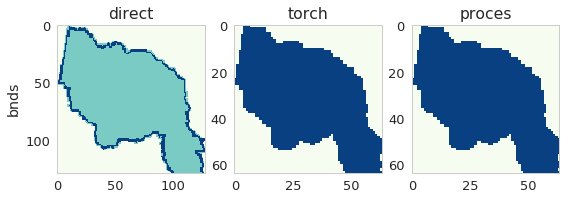

In [1016]:
dat, atr, names = next(loader)

mu_smpl = dat.numpy().mean((0,2,3))
sd_smpl = dat.numpy().std((0,2,3))
max_smpl= dat.numpy().max((0,2,3))
min_smpl= dat.numpy().min((0,2,3))

print "Mean", np.round(mu_smpl, 3).tolist()
print "Stdv", np.round(sd_smpl, 3).tolist()
print "Min ", np.round(min_smpl, 3).tolist()
print "Max ", np.round(max_smpl, 3).tolist()

i = 0

# data processed through torchvision
img = dat[i].numpy()

# data read directly
img_path = "/home/data/world-cities/spatial-maps/splits/train/%s.tif" % names[i]
img0 = imread(img_path)
img1 = basic_preprocess(img0.copy(), res_scale, 
                        normalize=normalize, log=take_log)

print names[i]
print "direct:", ["%2.4f-%2.4f"%x for x in zip(img0.min((0,1)), img0.max((0,1)))]
print "torch :", ["%2.4f-%2.4f"%x for x in zip(img.min((1,2)), img.max((1,2)))]
print "prepr:", ["%2.4f-%2.4f"%x for x in zip(img1.min((0,1)), img1.max((0,1)))]

prc = ["direct", "torch", "proces"]
src = ["bldg", "pop", "lum", "water", "bnds"]

for i,r in enumerate(src):
    fig, ax = plt.subplots(1,3, figsize=(9,6))
    ax[0].imshow(img0[...,i], cmap=cm.GnBu); ax[0].set_ylabel(r)
    ax[1].imshow(img[i,...], cmap=cm.GnBu);
    ax[2].imshow(img1[...,i], cmap=cm.GnBu)
    for a,s in zip(ax,prc):
        # a.axis("off")
        a.set_title(s)

In [833]:
# identify images with no data on relevant channels and remove them
mean_channels = dat.numpy().mean((2,3))

idx_rm = []
for i in range(mean_channels.shape[1]-1):
    print "Channel %d:"%i, (mean_channels[:,i]==0).sum()
    idx_rm += np.where((mean_channels[:,i]==0))[0].tolist()
    
for i in idx_rm:
    f1 = "/home/data/world-cities/spatial-maps/splits/train/%s.tif"%names[i]
    f2 = "/home/data/world-cities/spatial-maps/splits/train/%s.pickle.gz"%names[i]
    os.remove(f1)
    os.remove(f2)

# Channel 0: 3
# Channel 1: 1
# Channel 2: 16
# Channel 3: 0

Channel 0: 3
Channel 1: 1
Channel 2: 16
Channel 3: 0


In [862]:
A = np.arange(12).reshape((2,2,3))
print A
flip_ndimage(A)

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]


array([[[ 2,  1,  0],
        [ 5,  4,  3]],

       [[ 8,  7,  6],
        [11, 10,  9]]])

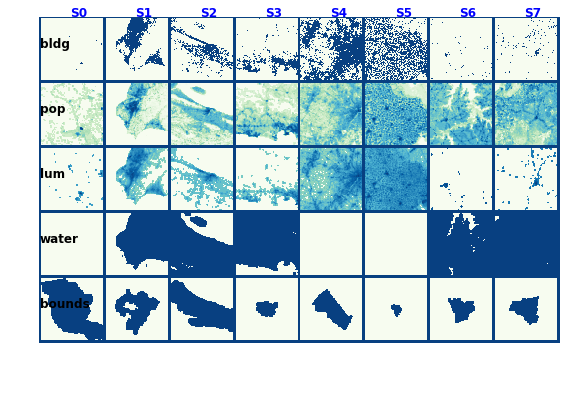

In [1017]:
plt.figure(figsize=(16,6))
ndarr = save_image_channels(dat, #filename="./bla.png", 
                            ncol=8, padding=3, take_log=True, #[1,2],
                            scale_each=False, normalize=False,
                   channel_names=["bldg", 'pop', 'lum', 'water', 'bounds'],
                   sample_names=["S%d"%i for i in range(10)])

In [1009]:
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City


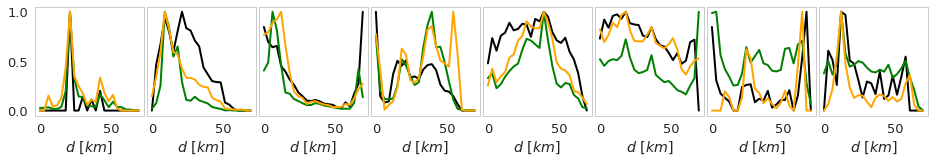

In [1033]:
cities = []
for i in range(8):
    M = dat[i,:3].numpy().transpose((1,2,0))
    water = dat[i,3].numpy() == 0
    bounds = dat[i,4].numpy()
    cities += [City(M, name="S%d"%i, 
                    mask=None, bounds=bounds, 
                    sources=["built", "pop", "lum"])]    
    
colormap = {"built":"black", "pop":"green", "lum":"orange", "all":"blue"}
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# using radial estimation method
sns.set_context("notebook", font_scale=1.3)
fig, ax = plt.subplots(1,8, figsize=(16,2), 
                       gridspec_kw={"wspace":0.03, "hspace":0.25},
                       sharex=True, sharey=True)


for i,city in enumerate(cities):
    profiles = city.compute_profile(method="radial", step=2, scale=False)

    L = len(profiles.values()[0][0])
    xlabels = np.arange(L) * 0.75 * 4

    for c,p in profiles.iteritems():
        s = np.nanmax(p[0])
        s = 1 if s == 0 else s
        ax[i].plot(xlabels, p[0] / s, label=c, lw=2, color=colormap[c])
    # ax[i].legend(loc="best")
    ax[i].set_xlabel("$d \ [km]$")

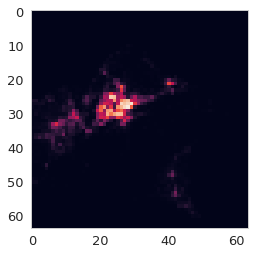

In [1030]:
plt.imshow(dat[1,1].numpy())

In [1001]:
p

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03125   ,  0.06944444,  0.07291667,  0.01785714,  0.0390625 ,
         0.025     ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00480769,  0.01388889,  0.00833333,  0.        ,
         0.01724138,  0.03819444,  0.03676471,  0.03571429,  0.04464286,
         0.053125  ,  0.03869048,  0.04573171,  0.04545455,  0.046875  ,
         0.03651685,  0.01966292,  0.03666667,  0.0625    ,  0.06854839,
         0.0875    ,  0.05978261,  0.06617647,  0.07352941,  0.05769231,
         0.03125   ,  0.0125    ,  0.025     ,  0.07142857,  0.08333333,
         0.        ,  0.        ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan]),
 array([ 0.        ,  0.        ,  0.        ,  0

In [930]:
fig, ax = plt.subplots(dat.size()[:2][::-1])
ax = ax.flatten()

for i in range(dat.size()[0]):
    for c in range(dat.size()[1]):
        plt.imshow(dat.numpy()[i,...].transpose((1,2,0))

(8, 5, 64, 64)